In [ ]:
%reload_ext autoreload
%autoreload 2

In [2]:
from nbc_analysis.utils.debug_utils import runit
from test_partition_by_viewer import test_partition_by_viewer, _get_config
from pathlib import Path
from toolz import concat, first
import pandas as pd
%matplotlib inline

In [18]:
CONFIG = _get_config()
CONFIG

2019-10-16 09:51:50,846|WARNING|nbc_analysis.utils.config_utils|The 'default' config is intended for testing only. For production, use /Users/wmcabee/.config/nbc_analysis/config.yaml
2019-10-16 09:51:50,847|WARNING|nbc_analysis.utils.config_utils|Overriding config file values with : BATCHES_D=/Users/wmcabee/Dropbox (Cognitive Scale)/NBC Analysis/data/NBC2/batches


{'CALENDAR_START_DAY_KEY': '20170101',
 'CALENDAR_END_DAY_KEY': '20210101',
 'CALENDAR_D': '/Users/wmcabee/DATA/NBC/calendar',
 'ANALYSIS_D': '/Users/wmcabee/DATA/NBC/ana',
 'RUNS_D': '/Users/wmcabee/DATA/NBC/runs',
 'WORK_D': '/Users/wmcabee/DATA/NBC/work',
 'VIDEO_END_BUCKET': 'nbc-event',
 'VIDEO_END_PARTITIONS_BUCKET': 'nbc-partitions-video-end-protect',
 'GEN_PROFILE_SOURCE': 'nbc-partitions-video-end',
 'BATCH_SIZE': 200000000,
 'GEOLITE2_DB': '/Users/wmcabee/DATA/NBC/datasets/GeoLite2-City_20191001/GeoLite2-City.mmdb',
 'VIEWER_SOURCE_BUCKET': 'nbc-events-partitioned',
 'VIEWER_PARTITION_NUM': 60,
 'VIEWER_PARTITION_D': '/Users/wmcabee/DATA/NBC/viewer_partitions',
 'LIMIT_FILES_PER_DAY': 20,
 'BATCH_LIMIT': 2,
 'BATCH_FILES_LIMIT': 2,
 'MERGE_LIMIT': 2,
 'PROFILE_PER_WEEK_LIMIT': 1000,
 'BATCHES_D': '/Users/wmcabee/Dropbox (Cognitive Scale)/NBC Analysis/data/NBC2/batches'}

In [22]:
%%time 
df = runit(test_partition_by_viewer)


2019-10-16 09:53:32,652|WARNING|nbc_analysis.utils.config_utils|The 'default' config is intended for testing only. For production, use /Users/wmcabee/.config/nbc_analysis/config.yaml
2019-10-16 09:53:32,654|WARNING|nbc_analysis.utils.config_utils|Overriding config file values with : BATCHES_D=/Users/wmcabee/Dropbox (Cognitive Scale)/NBC Analysis/data/NBC2/batches
2019-10-16 09:53:36,488|INFO|nbc_analysis.utils.aws_utils|end s3 download,key=clean/year=2019/week=2019W40/ve_20190930_0000.parquet
2019-10-16 09:53:37,192|INFO|nbc_analysis.utils.aws_utils|end s3 download,key=clean/year=2019/week=2019W40/ve_20190930_0001.parquet
2019-10-16 09:53:37,716|INFO|nbc_analysis.utils.aws_utils|end s3 download,key=clean/year=2019/week=2019W40/ve_20190930_0002.parquet
2019-10-16 09:53:38,278|INFO|nbc_analysis.utils.aws_utils|end s3 download,key=clean/year=2019/week=2019W40/ve_20190930_0003.parquet
2019-10-16 09:53:38,805|INFO|nbc_analysis.utils.aws_utils|end s3 download,key=clean/year=2019/week=2019W40

!! stopping run early... None
CPU times: user 739 ms, sys: 364 ms, total: 1.1 s
Wall time: 13.7 s


### Deserialize from disk

In [25]:
%%time
viewer_partition_d = Path(CONFIG['WORK_D'])
viewer_partition_d
reader = viewer_partition_d.glob('*')
reader = map(pd.read_parquet, reader)
df= pd.concat(reader)
DATA = df
print('records:', len(DATA))

records: 1787301
CPU times: user 6.09 s, sys: 784 ms, total: 6.88 s
Wall time: 4.45 s


## Define partitions

In [27]:
%%time
df = DATA
df['viewer_partition'] = df.mpid % 60
reader = df.groupby('viewer_partition')
for x in reader: pass

CPU times: user 3.2 s, sys: 133 ms, total: 3.33 s
Wall time: 3.33 s


In [40]:
stats = pd.DataFrame.from_records( [('download_from_s3', 13.7),
                 ('deserialize_from_disk', 4.45),
                 ('define_partitions',  3.33)], columns=['Step', 'duration_secs'] )

stats['records'] = len(df)
stats['krecs_per_sec'] = stats.records.div(stats.duration_secs).div(1000).round(1)
stats.sort_values('krecs_per_sec', inplace=True)

stats.set_index('Step', inplace=True)
stats

,duration_secs,records,krecs_per_sec
Step,,,
download_from_s3,13.70,1787301,130.5
deserialize_from_disk,4.45,1787301,401.6
define_partitions,3.33,1787301,536.7


Text(0, 0.5, 'Processing Rate (K Rows/Second)')

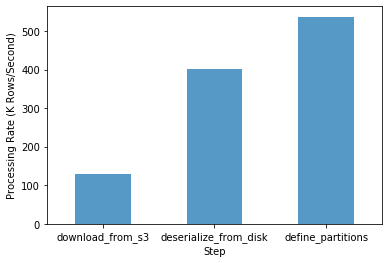

In [39]:
ax = stats.krecs_per_sec.plot(kind='bar', alpha=0.75, rot=0)
ax.set_ylabel('Processing Rate (K Rows/Second)')